In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import auc,accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids,TomekLinks,NeighbourhoodCleaningRule,NearMiss

def down_sampling(X,y,down_sampling_type,info):
    '''refer : https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8'''
    
    #random under sampling
    if down_sampling_type == 'random':
        sampler = RandomUnderSampler(sampling_strategy = 15/85,random_state=0)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After random down sampling {}'.format(Counter(y_ds)))
        return X_ds,y_ds
    
    #nearmiss under sampling
    if down_sampling_type == 'nearmiss':
        sampler = NearMiss(sampling_strategy = 15/85)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After nearmiss down sampling {}'.format(Counter(y_ds)))        
    return X_ds,y_ds

#------------------------------------------------------------------------
    
def up_sampling(X,y,info):
    
    #up sampling
    sm = SMOTE(sampling_strategy = 30/70,random_state=0 )
    X_us, y_us = sm.fit_sample(X, y)
    if info:
        print('After SMOTE up sampling {}'.format(Counter(y_us)))
    return X_us,y_us

#------------------------------------------------------------------------
    
def re_sampling(X,y,info,sampling_type,down_sampling_type):
    
    if sampling_type=='none':
        if info:
            print('split as in original data {}'.format(Counter(y)))
        return X,y

    if sampling_type=='down_sampling':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        return X_ds,y_ds
    
    if sampling_type=='up_sampling':
        X_us,y_us = up_sampling(X,y,info=info)
        return X_us,y_us
    
    if sampling_type=='hybrid':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        X_hs,y_hs = up_sampling(X_ds,y_ds,info=info)
        return X_hs,y_hs

#----------------------------------------------------------------------------------

def train_test_resampled_split(X,y,info,sampling_type,down_sampling_type,test_size):  
    
    if info:
        print('Before sampling {}'.format(Counter(y)))
    X_rs,y_rs = re_sampling(X,y,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    
    
    X_train,X_test,y_train,y_test = train_test_split(X_rs,y_rs,test_size=test_size,random_state=0,stratify=y_rs)
    
    print('-'*50)
    
    return X_train,X_test,y_train,y_test

#----------------------------------------------------------------------------------

def cutoff_point(model,X,y,info,test_size,sampling_type,down_sampling_type,cv_search):

    X_train,X_test,y_train,y_test = train_test_resampled_split(X=X,y=y,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    if cv_search != True:
        model[1].fit(X_train, y_train)

    prd = model[1].predict(X_test)
    proba = model[1].predict_proba(X_test)
    
    y_pred_df = pd.DataFrame(proba)
    y_pred_1 = y_pred_df.iloc[:,1]
    y_test_df = pd.DataFrame(y_test)

    y_pred_1.reset_index(drop=True, inplace=True)
    y_test_df.reset_index(drop=True, inplace=True)

    y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
    y_pred_final= y_pred_final.rename(columns={ 0:'readmitted',1 : 'readmitted_probability'})
    y_pred_final['predicted'] = y_pred_final.readmitted_probability.map( lambda x: 1 if x > 0.5 else 0)
   

    numbers = [float(x)/100 for x in range(100)]
    for i in numbers:
        y_pred_final[i]= y_pred_final.readmitted_probability.map( lambda x: 1 if x > i else 0)
    y_pred_final.head()

    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity','var_ssa','recall','precision','var_pra','Area Under Curve'])
    from sklearn.metrics import confusion_matrix
    
    for i in numbers:
        cm1 = confusion_matrix( y_pred_final.readmitted, y_pred_final[i] )
        total1=sum(sum(cm1))
        
        tp = cm1[0,0]
        tn = cm1[1,1]
        fp = cm1[1,0]
        fn = cm1[0,1]
        
        accuracy = (tp+tn)/total1
        
        sensi = tp/(tp+fn)
        speci = tn/(tn+fp)
        
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        
        var_ssa = np.std([accuracy,sensi,speci])
        var_pra = np.std([accuracy,recall,precision])
        
        fpr, tpr, thresholds = roc_curve(y_pred_final.readmitted, y_pred_final[i])
        auc = metrics.auc(fpr, tpr)
        
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci,var_ssa,recall,precision,var_pra,auc]

    print('-'*50)
    print('Finding Optimal Cutoff Point based on accuracy, recall, precision')
    cutoff_df.plot.line(x='prob', y=['accuracy','recall','precision'])
    plt.show()
    optimum_pra = cutoff_df.iloc[cutoff_df['var_pra'].argmin()]
    print('Optimum cutoff probability is {0:.2f}'.format(optimum_pra[0]))
    
    optimum_accuracy = accuracy_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_precision = precision_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_recall = recall_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_roc_auc = roc_auc_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    
    print("Accuracy is {0:.2f}".format(optimum_accuracy))
    print("Precision is {0:.2f}".format(optimum_precision))
    print("Recall is {0:.2f}".format(optimum_recall))
    print("ROC_AUC Score is {0:.2f}".format(optimum_roc_auc))
    
    result_for_optimized.loc[model[0]+'_OC'] = [optimum_accuracy,optimum_precision,optimum_recall,optimum_roc_auc]
    
    print("\nClassification report\n",classification_report(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    print("confusion matrix \n\n", confusion_matrix(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    
    return cutoff_df

#----------------------------------------------------------------------------------

def plot_roc_curve(y_true,proba):
    fpr, tpr, threshold = roc_curve(y_true, proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#----------------------------------------------------------------------------------
    
def model_check(model,X,y,sampling_type,down_sampling_type,test_size=0.15,cv_search=False,info=False):
    
    print(model[0])
    print('-'*50)
    
    if cv_search :
        
        print('Data set Before resampling {}'.format(Counter(y)) if info else '')
        
        X_train,X_test,y_train,y_test, = train_test_resampled_split(X,y,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type,info=info)
        
        print('Train set After resampling {}'.format(Counter(y_train)))
        print('Test set After resampling {}'.format(Counter(y_test)))
            
        model[1].fit(X_train, y_train)
        prd = model[1].predict(X_test)
        proba = model[1].predict_proba(X_test)[:,1]

        accuracy = accuracy_score(y_test, prd)
        precision = precision_score(y_test, prd)
        recall = recall_score(y_test, prd)
        roc_auc = roc_auc_score(y_test,proba)

        print("Accuracy is {0:.2f}".format(accuracy))
        print("Precision is {0:.2f}".format(precision))
        print("Recall is {0:.2f}".format(recall))
        print("ROC_AUC Score is {0:.2f}".format(roc_auc))
        plot_roc_curve(y_test,proba)
        print("\nClassification report\n",classification_report(y_test, prd))
        print("confusion matrix \n\n", confusion_matrix(y_test,prd)) 
        print('-'*50)
        print('best_parameters')
        print(model[1].best_params_)
        
        result.loc[model[0]] = [accuracy,precision,recall,roc_auc]

        
    else : 
    
        kf = model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
        i=1
        cv_results=[]
        cv_df = pd.DataFrame( columns = ['kfold','accuracy','recall','precision','ROC_AUC'])
        for train_index,test_index in kf.split(X,y):
            print('{} of KFold {}'.format(i,kf.n_splits))

            xtr,xte = X.loc[train_index],X.loc[test_index]
            ytr,yte = y.loc[train_index],y.loc[test_index]

            X_tr_rs,y_tr_rs = re_sampling(xtr,ytr,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            X_te_rs,y_te_rs = re_sampling(xte,yte,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            model[1].fit(X_tr_rs, y_tr_rs)
            y_pred = model[1].predict(X_te_rs)
            y_proba = model[1].predict_proba(X_te_rs)[:,1]

            accuracy = accuracy_score(y_te_rs, y_pred)
            precision = precision_score(y_te_rs, y_pred)
            recall = recall_score(y_te_rs, y_pred)
            roc_auc = roc_auc_score(y_te_rs,y_proba)
            
            cv_df.loc[i] =[ i ,accuracy,recall,precision,roc_auc]
            '''print("\nAccuracy is {0:.2f}".format(accuracy))
            print("Precision is {0:.2f}".format(precision))
            print("Recall is {0:.2f}".format(recall))
            print("ROC_AUC Score is {0:.2f}".format(roc_auc))

            plot_roc_curve(y_te_rs,y_proba)

            print("\nClassification report\n",classification_report(y_te_rs, y_pred))
            print("confusion matrix \n\n", confusion_matrix(y_te_rs,y_pred))
            print('-'*50)'''

            i+=1    

        print('\n\n',cv_df)
        print('\nAverage accuracy after k-fold = {}'.format(np.mean(cv_df['accuracy'])))
        print('Average recall after k-fold = {}'.format(np.mean(cv_df['recall'])))
        print('Average precision after k-fold = {}'.format(np.mean(cv_df['precision'])))
        print('Average ROC_AUC after k-fold = {}'.format(np.mean(cv_df['ROC_AUC'])))
    
        result.loc[model[0]] = [np.mean(cv_df['accuracy']),np.mean(cv_df['precision']),np.mean(cv_df['recall']),np.mean(cv_df['ROC_AUC'])]
    
    print('-'*50)
    print('\n')
    cutoff_df = cutoff_point(model,X,y,cv_search=cv_search,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

    return 

result = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])
result_for_optimized = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])

In [2]:
data = pd.read_csv('final_data.csv')
X = data.drop('readmitted',axis=1)
y = data['readmitted']

Random Forest Classifier
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.819485  0.540275   0.791747  0.861327
2     2.0  0.842860  0.586771   0.841315  0.880892
3     3.0  0.831699  0.568999   0.813845  0.874740
4     4.0  0.833464  0.563113   0.826296  0.881058
5     5.0  0.830522  0.553957   0.823129  0.872418
6     6.0  0.821842  0.537001   0.803922  0.859376
7     7.0  0.830289  0.549443   0.826601  0.875668
8     8.0  0.838342  0.561231   0.848515  0.881349
9     9.0  0.837949  0.584807   0.823801  0.879288
10   10.0  0.831074  0.554028   0.825366  0.868355

Average accuracy after k-fold = 0.8317527049287895
Average recall after k-fold = 0.5599625318498551
Average precision after k-fold = 0.8224534743865629
Average ROC_AUC after k-fold = 0.8734470582390186
----------------

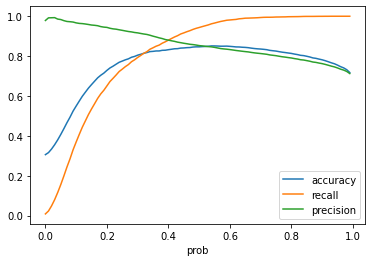

Optimum cutoff probability is 0.40
Accuracy is 0.83
Precision is 0.72
Recall is 0.72
ROC_AUC Score is 0.80

Classification report
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      5349
           1       0.72      0.72      0.72      2293

    accuracy                           0.83      7642
   macro avg       0.80      0.80      0.80      7642
weighted avg       0.83      0.83      0.83      7642

confusion matrix 

 [[4708  641]
 [ 641 1652]]


In [3]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
model = ['Random Forest Classifier',rf]
model_check(model,X,y,sampling_type='hybrid',down_sampling_type='random',cv_search=False,info=False)

Random Forest Classifier with Randomsearch CV
--------------------------------------------------

--------------------------------------------------
Train set After resampling Counter({0: 28528, 1: 12225})
Test set After resampling Counter({0: 7132, 1: 3057})
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 59.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 67.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 73.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 80.8min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000

Accuracy is 0.76
Precision is 0.84
Recall is 0.24
ROC_AUC Score is 0.82


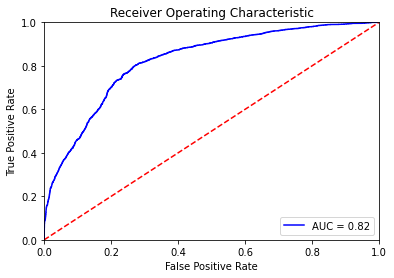


Classification report
               precision    recall  f1-score   support

           0       0.75      0.98      0.85      7132
           1       0.84      0.24      0.37      3057

    accuracy                           0.76     10189
   macro avg       0.79      0.61      0.61     10189
weighted avg       0.78      0.76      0.71     10189

confusion matrix 

 [[6987  145]
 [2320  737]]
--------------------------------------------------
best_parameters
{'min_samples_split': 35, 'min_samples_leaf': 14, 'max_leaf_nodes': 15, 'max_depth': 35, 'criterion': 'entropy'}
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------
Finding Optimal Cutoff Point based on accuracy, recall, precision


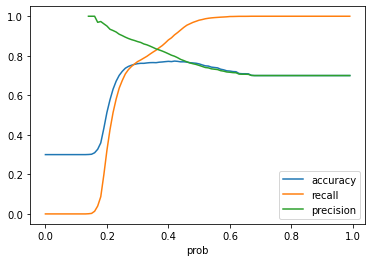

Optimum cutoff probability is 0.36
Accuracy is 0.77
Precision is 0.61
Recall is 0.62
ROC_AUC Score is 0.72

Classification report
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      7132
           1       0.61      0.62      0.61      3057

    accuracy                           0.77     10189
   macro avg       0.72      0.72      0.72     10189
weighted avg       0.77      0.77      0.77     10189

confusion matrix 

 [[5908 1224]
 [1169 1888]]


In [11]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

params = {'max_depth':range(1,40),
             'min_samples_leaf':range(1,20),
             'min_samples_split':range(1,40),
             'criterion':['entropy','gini'],
             'max_leaf_nodes': (1,15)}

#hyperparameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, criterion=criterion)

rf_rcv = ['Random Forest Classifier with Randomsearch CV',RandomizedSearchCV(rf, params, random_state=1, n_iter=1000, cv=10, verbose=1, n_jobs=-1,scoring = "roc_auc")]
model_check(rf_rcv,X,y,test_size=0.20,sampling_type='hybrid',down_sampling_type='nearmiss',cv_search=True,info=False)

In [23]:
result

,Accuracy,Precision,Recall,AUC_ROC
Random Forest Classifier,0.831753,0.822453,0.559963,0.873447
Random Forest Classifier with Randomsearch CV,0.758072,0.835601,0.241086,0.823796
Boosted_LR,0.864387,0.819823,0.702409,0.912479


In [24]:
result_for_optimized

,Accuracy,Precision,Recall,AUC_ROC
Random Forest Classifier_OC,0.832243,0.720454,0.720454,0.800309
Random Forest Classifier with Randomsearch CV_OC,0.765139,0.606684,0.617599,0.722989
Boosted_LR_OC,0.857105,0.814563,0.678151,0.805985


In [31]:
fin_res = pd.concat([result,result_for_optimized],axis=0)
fin_res.to_csv('fin_res_rf.csv')
fin_res

,Accuracy,Precision,Recall,AUC_ROC
Random Forest Classifier,0.831753,0.822453,0.559963,0.873447
Random Forest Classifier with Randomsearch CV,0.758072,0.835601,0.241086,0.823796
Boosted_LR,0.864387,0.819823,0.702409,0.912479
Random Forest Classifier_OC,0.832243,0.720454,0.720454,0.800309
Random Forest Classifier with Randomsearch CV_OC,0.765139,0.606684,0.617599,0.722989
Boosted_LR_OC,0.857105,0.814563,0.678151,0.805985


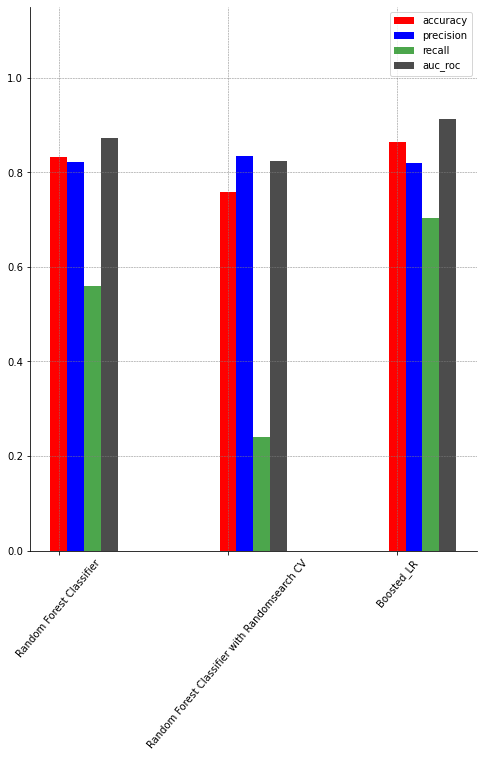

In [25]:
plt.figure(figsize=(8, 10))

ax = plt.subplot(111)

models = result.index
values = list(result['Accuracy'])
model = np.arange(len(result))

plt.bar(model, values, align='center', width = 0.1, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Precision'])
model = np.arange(len(result))

plt.bar(model+0.1, values, align='center', width = 0.1, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Recall'])
model = np.arange(len(result))

plt.bar(model+0.2, values, align='center', width = 0.1, alpha=0.7, color = 'Green', label= 'recall')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['AUC_ROC'])
model = np.arange(len(result))

plt.bar(model+0.3, values, align='center', width = 0.1, alpha=0.7, color = 'black', label= 'auc_roc')
plt.xticks(model, models,rotation=50,size=10)
plt.yticks(size=10)
ax.set_ylim(top=1.15)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 10})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')

plt.show() 

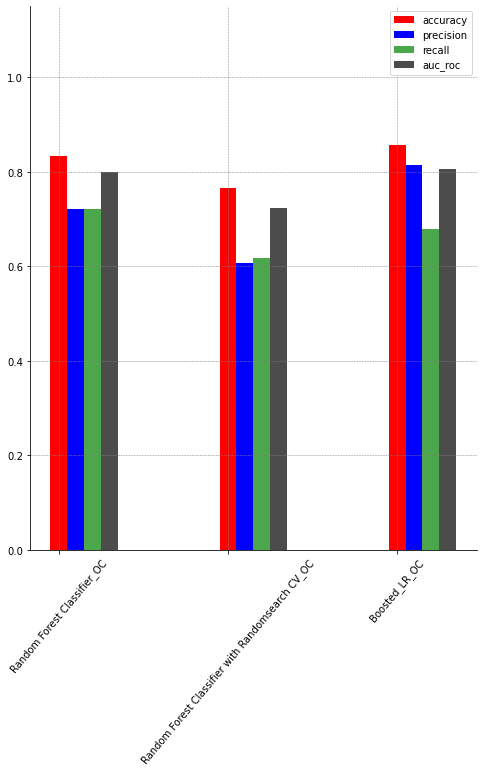

In [26]:
plt.figure(figsize=(8, 10))

ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Accuracy'])
model = np.arange(len(result_for_optimized))

plt.bar(model, values, align='center', width = 0.1, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Precision'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.1, values, align='center', width = 0.1, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Recall'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.2, values, align='center', width = 0.1, alpha=0.7, color = 'Green', label= 'recall')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['AUC_ROC'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.3, values, align='center', width = 0.1, alpha=0.7, color = 'black', label= 'auc_roc')
plt.xticks(model, models,rotation=50,size=10)
plt.yticks(size=10)
ax.set_ylim(top=1.15)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 10})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')

plt.show() 

In [12]:
X_rs,y_rs = re_sampling(X,y,sampling_type='hybrid',down_sampling_type='nearmiss',info=False)

In [15]:
rf = RandomForestClassifier(criterion='entropy', max_depth=35,min_samples_leaf=14, min_samples_split=35,max_leaf_nodes=15,random_state=0)

no. of estimator 1
no. of estimator 2
no. of estimator 3
no. of estimator 4
no. of estimator 5
no. of estimator 6
no. of estimator 7
no. of estimator 8
no. of estimator 9
no. of estimator 10
no. of estimator 11
no. of estimator 12
no. of estimator 13
no. of estimator 14
no. of estimator 15
no. of estimator 16
no. of estimator 17
no. of estimator 18
no. of estimator 19
no. of estimator 20
no. of estimator 21
no. of estimator 22
no. of estimator 23
no. of estimator 24
no. of estimator 25
no. of estimator 26
no. of estimator 27
no. of estimator 28
no. of estimator 29
no. of estimator 30
no. of estimator 31
no. of estimator 32
no. of estimator 33
no. of estimator 34
no. of estimator 35
no. of estimator 36
no. of estimator 37
no. of estimator 38
no. of estimator 39
no. of estimator 40
no. of estimator 41
no. of estimator 42
no. of estimator 43
no. of estimator 44
no. of estimator 45
no. of estimator 46
no. of estimator 47
no. of estimator 48
no. of estimator 49


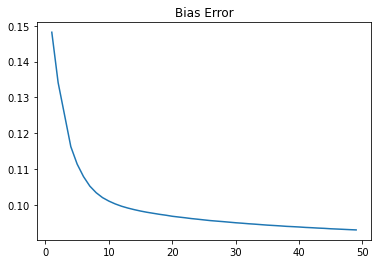

best n_estimator based on bias error =  49


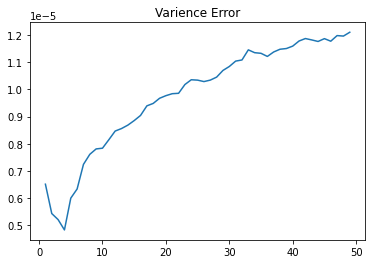

best n_estimator based on variance error =  4


In [16]:
from sklearn.ensemble import AdaBoostClassifier

Ada_rf_bias=[]
Ada_rf_var =[]
for val in np.arange(1,50):
    Ada_rf=AdaBoostClassifier(base_estimator=rf,n_estimators=val,random_state=0)
    kfold = model_selection.KFold(shuffle=True,n_splits=10,random_state=0)
    cv_results = model_selection.cross_val_score(Ada_rf, X_rs, y_rs,cv=kfold, scoring='roc_auc')
    Ada_rf_bias.append(1-np.mean(cv_results))
    Ada_rf_var.append(np.var(cv_results,ddof=1))
    print(f'no. of estimator {val}')

x_axis=np.arange(1,50)
plt.plot(x_axis,Ada_rf_bias)
plt.title('Bias Error')
plt.show()
print('best n_estimator based on bias error = ',(np.argmin(Ada_rf_bias)+1))
plt.plot(x_axis,Ada_rf_var)
plt.title('Varience Error')
plt.show()
print('best n_estimator based on variance error = ',(np.argmin(Ada_rf_var)+1))

In [18]:
Ada_rf_result = pd.DataFrame()
Ada_rf_result['N-Estimators'] = np.arange(1,50)
Ada_rf_result['Variance Error'] = Ada_rf_var
Ada_rf_result['Bias Error'] = Ada_rf_bias
Ada_rf_result.sort_values('Bias Error').head()

,N-Estimators,Variance Error,Bias Error
48,49,0.000012,0.093088
47,48,0.000012,0.093162
46,47,0.000012,0.093248
45,46,0.000012,0.093329
44,45,0.000012,0.093406


In [20]:
best_boost_est = int(Ada_rf_result.sort_values('Bias Error').head(1)['N-Estimators'].values)
best_boost_est

49

In [21]:
boosted_rf=['Boosted_LR',AdaBoostClassifier(base_estimator=rf,n_estimators=best_boost_est,random_state=0)]

Boosted_LR
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.852092  0.686968   0.792296  0.902715
2     2.0  0.872324  0.717747   0.833460  0.920589
3     3.0  0.857984  0.704382   0.798369  0.907795
4     4.0  0.862691  0.707652   0.810487  0.913280
5     5.0  0.861318  0.691956   0.817620  0.912827
6     6.0  0.860735  0.695481   0.813170  0.910712
7     7.0  0.864270  0.690897   0.828100  0.913921
8     8.0  0.873502  0.715128   0.839354  0.922737
9     9.0  0.877627  0.719057   0.849845  0.916477
10   10.0  0.861324  0.694826   0.815527  0.903741

Average accuracy after k-fold = 0.8643866833516235
Average recall after k-fold = 0.7024094316259798
Average precision after k-fold = 0.8198228503656434
Average ROC_AUC after k-fold = 0.9124793847488066
------------------------------

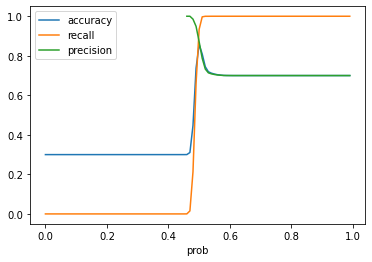

Optimum cutoff probability is 0.50
Accuracy is 0.86
Precision is 0.81
Recall is 0.68
ROC_AUC Score is 0.81

Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      5349
           1       0.81      0.68      0.74      2293

    accuracy                           0.86      7642
   macro avg       0.84      0.81      0.82      7642
weighted avg       0.85      0.86      0.85      7642

confusion matrix 

 [[4995  354]
 [ 738 1555]]


In [22]:
model_check(boosted_rf,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',cv_search=False,info=False)